In [ ]:
import numpy as np
import itertools
import scipy
import pandas as pd
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Initializing Test Data

In [ ]:
# The Koch curve has a known theoretical dimension of ~1.261
koch_curve_url = 'https://raw.githubusercontent.com/ninavergara605/dimension_analysis/master/koch_curve.csv'
koch_curve = pd.read_csv(koch_curve_url, nrows=160).squeeze().str.split(" ", expand=True).apply(pd.to_numeric, errors='ignore').values

# These curves simulate VR paths
random_walk_rough = pd.read_csv('/content/gdrive/MyDrive/dimension_analysis/rough_random_walk.csv').values
random_walk_smooth = pd.read_csv('/content/gdrive/MyDrive/dimension_analysis/smooth_random_walk.csv').values

# Shift the y-values to ensure they're greater than 0
random_walk_rough[:,1] = random_walk_rough[:,1] + -min(random_walk_rough[:,1])
random_walk_smooth[:,1] = random_walk_smooth[:,1] + -min(random_walk_smooth[:,1])

## Implementation Walkthrough

### Creating the Initial Grid

 Each axis will share the same grid intercept points to ensure the boxes are square



In [ ]:
# Find the largest x or y point value to determine the maximum dimension of the grid
max_dim = np.max(koch_curve)

# In this example, the grid is split into 5 segments on both the x and y axis.
nboxes = 4
n_divides = int(np.sqrt(nboxes))

# np.linspace is used to mark the segment intercept points for each axis of the grid
grid_intercepts = np.linspace(0, max_dim ,num=n_divides+1)
grid_intercepts

array([0.       , 2.4691358, 4.9382716])

 ### Dividing the Grid

 For every iteration, each segment of the grid is divided in half to create new
 intercepts

In [ ]:
def divide_intercepts(intercepts):
  divided = []
  for i in range(len(intercepts)-1):
    # Grabs a pair of intercept points based on index
    lower = intercepts[i]
    upper = intercepts[i+1]
    # Calculate the midpoint of the two values
    middle = lower + (upper - lower)/2
    
    # To avoid duplication, only add the lower value if it isn't present in the divided array  
    if lower in divided:
      divided.extend([middle, upper])
    else:
      divided.extend([lower, middle, upper])
  return divided
  
divided_intercepts = divide_intercepts(grid_intercepts)
divided_intercepts

[0.0,
 1.2345679012345687,
 2.4691358024691374,
 3.703703703703706,
 4.938271604938275]

### Visualizing the Path and Grid

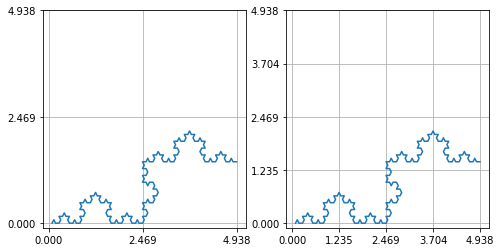

In [ ]:
# Initialize the plot
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(8,4))

def plot_path(ax, data, ticks):
  # Plots each point in the path
  ax.plot(data[:,0], data[:,1])
  # Use the grid segments for the X and Y axis to determine the major axis ticks
  ax.set_yticks(ticks)
  ax.set_xticks(ticks)
  ax.grid()
  
plot_path(ax1, koch_curve, grid_intercepts)
plot_path(ax2, koch_curve, divided_intercepts)

### Detecting if a Point Lies Within a Grid Box

1. Create a range to index the grid segments
2. Create a cartesian product of the grid segment ranges to determine box locations
3. Grab X and Y box boundaries for each index by retrieving the corresponding grid intercepts along with the preceding intercept
4. Determine if any points fall between these boundaries. If so, increment the counter

In [ ]:
# Create a range of indexes for the grid segments
idx_range = list(range(1, n_divides+1))

# Implements a Cartesian Product of the index range against itself
idxs = list(itertools.product(idx_range,idx_range))

nbox_intercepted = 0
for xi,yi in idxs:
  # Uses the grid indexes to grab box boundaries
  x0,x1 = grid_intercepts[xi-1], grid_intercepts[xi]
  y0,y1 = grid_intercepts[yi-1], grid_intercepts[yi]

  # Filter the path by returning points that fall within both the X and Y boundaries
  inside_box = koch_curve[(koch_curve[:,0] > x0) & (koch_curve[:,0]  <x1) & (koch_curve[:,1] > y0) & (koch_curve[:,1] < y1)]
  if len(inside_box) > 0:
      # If there are points inside the box boundaries, increment the counter
      nbox_intercepted += 1
nbox_intercepted

2

## Refactoring into a Function

In order to calculate the fractal dimension of the path, we need vary the number of boxes that a grid contains and return the number of intercepted boxes.

The function also returns the mean of the number of points found within each box, which will be used to flag when the number of boxes approach the resolution of the data

In [ ]:
def count_box_interceptions(_path, grid):
  # Create a range of indexes for the grid segments
  idx_range = list(range(1, len(grid)))

  # Implements a Cartesian Product of the index range against itself
  idxs = list(itertools.product(idx_range,idx_range))
  points_per_box = []
  nbox_intercepted = 0
  for xi,yi in idxs:
    # Uses the grid indexes to grab box boundaries
    x0,x1 = grid[xi-1], grid[xi]
    y0,y1 = grid[yi-1], grid[yi]

    # Filter the path by returning points that fall within both the X and Y boundaries
    points_in_box = _path[(_path[:,0] > x0) & (_path[:,0] < x1) & (_path[:,1] > y0) & (_path[:,1] < y1)]
    if len(points_in_box) > 0:
        # If there are points inside the box boundaries, increment the counter
        nbox_intercepted += 1
        points_per_box.append(len(points_in_box)) # Take note of the number of points in the box
  return nbox_intercepted, np.mean(points_per_box)

Constraints for determining the number of boxes


For the regression line, we want to exclude values where
*   Number of boxes equals 1 or 4
*   Number of boxes approaches the resolution of the data






In [ ]:
def grab_box_counts(_path):
  # Initialize arrays where interception box counts and grid size are held
  nbox_intercepted_all = []
  box_size = []

  # Initialize the grid intercepts with a 2x2 layout 
  grid_intercepts = np.linspace(0, np.max(_path), num=3)

  points_per_box = 666
  while  points_per_box > 1:
    # Divide the grid and store the box size
    grid_intercepts = divide_intercepts(grid_intercepts)
    box_size.append(grid_intercepts[1] - grid_intercepts[0])
    
    # Grab the number of boxes intercepted and the average number of points per box
    nbox_intercepted, points_per_box = count_box_interceptions(_path, grid_intercepts)
    nbox_intercepted_all.append(nbox_intercepted)

  return nbox_intercepted_all[:-1], box_size[:-1] # Exclude the last iteration from regression line

In [ ]:
def plot_regression_line(X, y_pred, y, dimension):
  fig, ax = plt.subplots()
  ax.plot(X,y, label='Box Count')
  ax.plot(X,y_pred,c='r', label='Regression Line')
  ax.invert_xaxis()
  
  ax.set_xlabel('log(s)')
  ax.set_ylabel('log(N(s))');
  ax.set_title(f'Dimension: {np.round(dimension[0],3)}');
  ax.legend();

def calculate_fractal_dimension(_path):
  N, magnification = grab_box_counts(_path)
  x = [np.log(1/s) for s in magnification]
  X = np.array(x).reshape(-1, 1)
  y = [np.log(n) for n in N]
  lr = LinearRegression(fit_intercept=True)
  lr.fit(X,y)
  y_pred = lr.predict(X)
  dimension = lr.coef_

  plot_regression_line(X, y_pred, y, dimension)
  return dimension

### Test Curve Preformance 

#### The Koch Curve
Theoretical dimension of the Koch curve: ~1.261


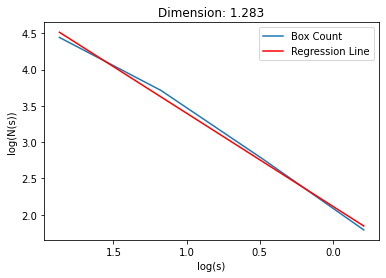

In [ ]:
calculate_fractal_dimension(koch_curve);

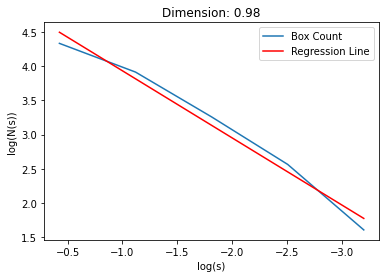

In [ ]:
calculate_fractal_dimension(random_walk_smooth);

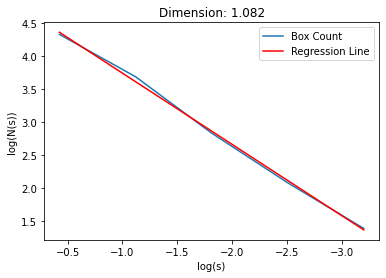

In [ ]:
calculate_fractal_dimension(random_walk_rough);